# Lending Club Data: Loan Risk Prediction Model

### Models

### Import required python library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_columns', None)

# Ploting options
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def confusion_matrix_display(model, title):
    plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['Charged Off','Fully Paid'],
                                 cmap=plt.cm.Blues,
                                normalize='all')
    plt.title(title)

In [3]:
df=pd.read_csv('loan_data_final_0.95.csv')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X = df.drop('loan_status',axis=1).values
y = df['loan_status'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

## Scale tad data after train test split

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()

In [9]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Sequntial Model

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [11]:
model = Sequential()
# input layer
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))

# hidden layear
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [12]:
#Early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [13]:
# CODE HERE
model.fit(x=X_train, 
          y=y_train, 
          epochs=10,
          batch_size=128,
          validation_data=(X_test, y_test),callbacks=[es])

Train on 788810 samples, validate on 197203 samples
Epoch 1/10
788810/788810 [==============================] - 10s 13us/step - loss: 0.0422 - val_loss: 0.0102
Epoch 2/10
788810/788810 [==============================] - 10s 13us/step - loss: 0.0128 - val_loss: 0.0111
Epoch 3/10
788810/788810 [==============================] - 10s 12us/step - loss: 0.0103 - val_loss: 0.0057
Epoch 4/10
788810/788810 [==============================] - 10s 12us/step - loss: 0.0091 - val_loss: 0.0064
Epoch 5/10
788810/788810 [==============================] - 10s 12us/step - loss: 0.0087 - val_loss: 0.0063
Epoch 6/10
788810/788810 [==============================] - 10s 12us/step - loss: 0.0080 - val_loss: 0.0067
Epoch 7/10
788810/788810 [==============================] - 10s 12us/step - loss: 0.0075 - val_loss: 0.0079
Epoch 8/10
788810/788810 [==============================] - 10s 12us/step - loss: 0.0073 - val_loss: 0.0060
Epoch 9/10
788810/788810 [==============================] - 10s 12us/step - loss: 0.

In [14]:
losses = pd.DataFrame(model.history.history)

Text(0.5, 0, 'Number of epochs')

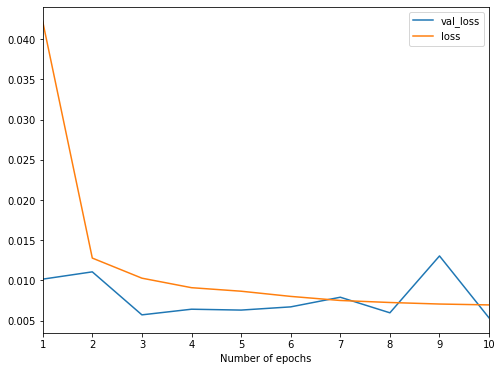

In [15]:
ax=losses.plot()
ax.set_xticklabels(np.arange(1,11))
plt.xlabel('Number of epochs')

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve

In [17]:
predictions_nw = model.predict_classes(X_test)

In [18]:
print(classification_report(y_test,predictions_nw,digits=3))

              precision    recall  f1-score   support

           0      0.999     0.994     0.997     38949
           1      0.999     1.000     0.999    158254

    accuracy                          0.999    197203
   macro avg      0.999     0.997     0.998    197203
weighted avg      0.999     0.999     0.999    197203



In [19]:
con_mat = confusion_matrix(y_test,predictions_nw)
labels = ['Charged Off','Fully Paid']

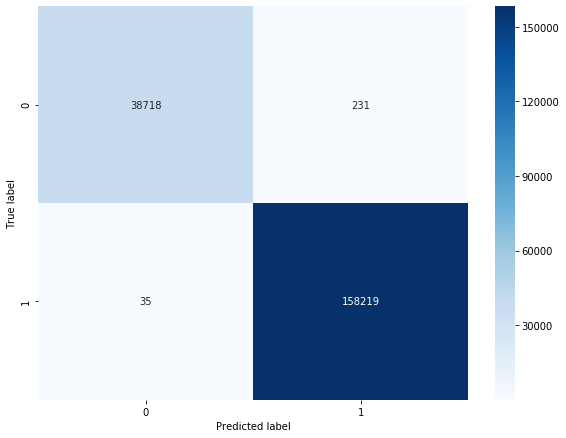

In [20]:
ax = sns.heatmap(con_mat, annot=True,fmt="d",cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
def new_costumer():
    import random
    random_ind = random.randint(0,len(X_test))

    #new_customer = df.drop('loan_paid',axis=1).iloc[random_ind]
    new_customer = pd.DataFrame(X_test).iloc[random_ind]
    predict = model.predict_classes(new_customer.values.reshape(1,X_train.shape[1]))[0][0]
    true = pd.DataFrame(y_test).iloc[random_ind][0]
    return true,predict

In [22]:
def sample_prediction(N):
    x = []
    y = []
    for _ in range(N):
        true,predict = new_costumer()
        x.append(true)
        y.append(predict)
    plt.figure(figsize=(15,5))
    plt.plot(x,'-r',label='True')
    plt.plot(y,'b^',label='Predicted')
    plt.legend()

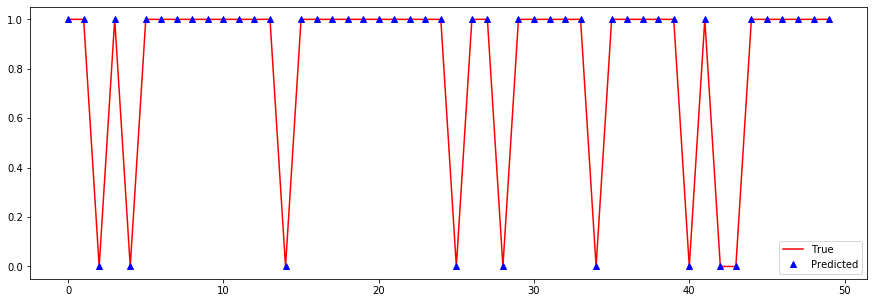

In [23]:
sample_prediction(50)

# Logistic regresion

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
predictions_lr = logmodel.predict(X_test)

In [27]:
print(classification_report(y_test,predictions_lr,digits=3))

              precision    recall  f1-score   support

           0      0.999     0.979     0.989     38949
           1      0.995     1.000     0.997    158254

    accuracy                          0.996    197203
   macro avg      0.997     0.989     0.993    197203
weighted avg      0.996     0.996     0.996    197203



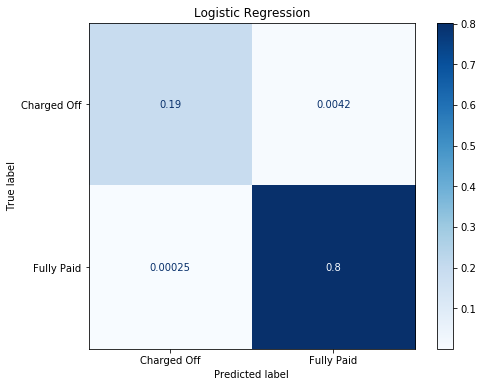

In [28]:
confusion_matrix_display(logmodel, 'Logistic Regression')

# Decision Tree Classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
dtree = DecisionTreeClassifier()

In [31]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [32]:
predictions_dt = dtree.predict(X_test)

In [33]:
print(classification_report(y_test,predictions_dt,digits=3))

              precision    recall  f1-score   support

           0      0.990     0.990     0.990     38949
           1      0.998     0.998     0.998    158254

    accuracy                          0.996    197203
   macro avg      0.994     0.994     0.994    197203
weighted avg      0.996     0.996     0.996    197203



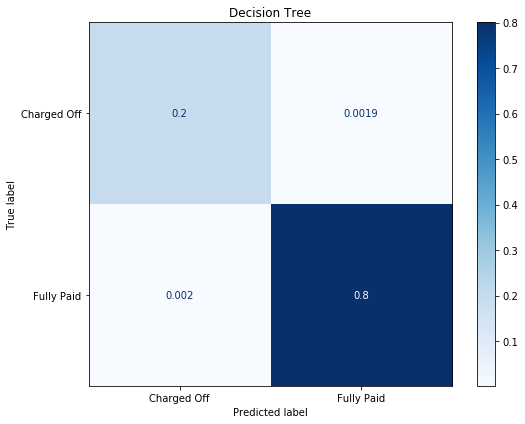

In [34]:
confusion_matrix_display(dtree, 'Decision Tree')
plt.tight_layout()

## Compare two models

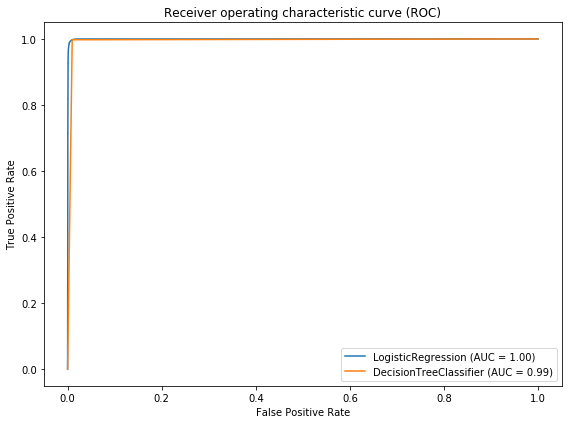

In [35]:
ax = plt.gca()
plot_roc_curve(logmodel, X_test, y_test,ax=ax)
plot_roc_curve(dtree, X_test, y_test,ax=ax)
plt.title('Receiver operating characteristic curve (ROC)')
plt.tight_layout()

**Both ROC curves are excellent with AUC values close to 1. There is not a significant difference between the two models.**

# Future work

 * Investigate each feature carefully and keep only those features that are available to inverter before investing.
 * Adjust MV_FEATURE, CV_MAX, and PC_MAX in the features selection
 * Choose the best model and parameter 